In [59]:
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')


In [60]:
users = pd.read_csv("/home/imman/Imman Codings/Assesement/Task 5/Resource/takehome_users.csv",encoding='unicode_escape')
users_engagement = pd.read_csv('/home/imman/Imman Codings/Assesement/Task 5/Resource/takehome_user_engagement.csv')

In [61]:
users.rename(columns={'object_id': 'user_id' },inplace=True)

In [62]:
users_engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [63]:
main = pd.merge(users,users_engagement,on='user_id',how='right')

In [64]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     207917 non-null  int64  
 1   creation_time               207917 non-null  object 
 2   name                        207917 non-null  object 
 3   email                       207917 non-null  object 
 4   creation_source             207917 non-null  object 
 5   last_session_creation_time  207917 non-null  float64
 6   opted_in_to_mailing_list    207917 non-null  int64  
 7   enabled_for_marketing_drip  207917 non-null  int64  
 8   org_id                      207917 non-null  int64  
 9   invited_by_user_id          116887 non-null  float64
 10  time_stamp                  207917 non-null  object 
 11  visited                     207917 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 20.6+ MB


### Converting Time COlumns

In [65]:
main['creation_time'] = pd.to_datetime(main['creation_time'])
main['time_stamp'] = pd.to_datetime(main['time_stamp'])
main['last_session_creation_time'] = pd.to_datetime(main['last_session_creation_time'],unit='s')

### Nan Values

In [66]:
main.isna().sum()/len(main)*100

user_id                        0.000000
creation_time                  0.000000
name                           0.000000
email                          0.000000
creation_source                0.000000
last_session_creation_time     0.000000
opted_in_to_mailing_list       0.000000
enabled_for_marketing_drip     0.000000
org_id                         0.000000
invited_by_user_id            43.781894
time_stamp                     0.000000
visited                        0.000000
dtype: float64

In [67]:
main.drop(columns='invited_by_user_id',axis=1,inplace=True)

In [68]:
#Creating week
main['week'] = main['last_session_creation_time'].dt.week
    

In [69]:
main.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'time_stamp', 'visited',
       'week'],
      dtype='object')

In [70]:
groupby_week = main.groupby(['user_id','week','creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id'])['visited'].count().reset_index()
groupby_week.tail(10)

,user_id,week,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited
8813,11989,36,SIGNUP_GOOGLE_AUTH,1,0,22,1
8814,11990,27,ORG_INVITE,0,0,25,1
8815,11991,22,SIGNUP_GOOGLE_AUTH,0,0,388,5
8816,11992,15,PERSONAL_PROJECTS,0,0,129,1
8817,11995,43,PERSONAL_PROJECTS,0,0,0,1
8818,11996,36,ORG_INVITE,0,0,89,1
8819,11997,3,SIGNUP_GOOGLE_AUTH,0,0,200,1
8820,11998,17,GUEST_INVITE,1,1,83,1
8821,11999,22,PERSONAL_PROJECTS,0,0,6,1
8822,12000,4,SIGNUP,0,1,0,1


In [71]:
adopted_user = groupby_week.loc[groupby_week['visited'] >= 3]
print("Total adopted users are - ",len(adopted_user))

Total adopted users are -  2248


In [72]:
groupby_week['adopted_user'] = groupby_week['visited'].apply(lambda x: 'yes' if x >= 3 else 'No') 

In [73]:
groupby_week.to_csv("Cleaned.csv")

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='count', ylabel='adopted_user'>

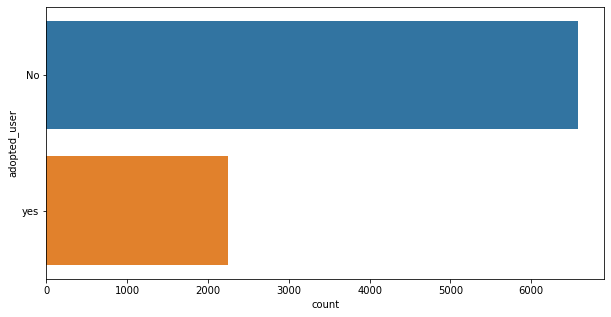

In [75]:
plt.figure(figsize=(10,5))
sns.countplot(y=groupby_week.adopted_user)

##  Label Encoding

In [76]:
from sklearn.preprocessing import LabelEncoder

In [77]:
le = LabelEncoder()


In [78]:
#LabelEncoding categorical columns
for column in groupby_week.columns:
   if groupby_week[column].dtype == object:
       groupby_week[column] = le.fit_transform(groupby_week[column])

## Model Creation

In [79]:
from sklearn.model_selection import train_test_split


In [80]:
X = groupby_week.drop(columns=['visited','user_id','adopted_user'],axis=1)
Y = groupby_week['adopted_user']

In [81]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=124)

In [82]:
print(x_train.shape)
print(x_test.shape)


(7058, 5)
(1765, 5)


## Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
randomforest = RandomForestClassifier(n_estimators=150,max_depth=12,random_state=1455)

In [85]:
randomforest.fit(x_train,y_train)

RandomForestClassifier(max_depth=12, n_estimators=150, random_state=1455)

In [86]:
randomforest_score = randomforest.score(x_test,y_test)*100

In [87]:
print("Random Forest Score is ",randomforest_score) 

Random Forest Score is  80.11331444759206


## Decision Tree Classifier

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
decisiontree = DecisionTreeClassifier(random_state=15,max_depth=0.1)

In [90]:
decisiontree.fit(x_train,y_train)


DecisionTreeClassifier(max_depth=0.1, random_state=15)

In [91]:
decisiontree_score=decisiontree.score(x_test,y_test)*100
print("Decision Tree Score is :",decisiontree_score)

Decision Tree Score is : 74.3342776203966


## Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [93]:
logiregres = LogisticRegression()

In [94]:
logiregres.fit(x_train,y_train)

LogisticRegression()

In [95]:
logistic_regression_Score = logiregres.score(x_test,y_test)*100
print("Logistic Regression score is :",logistic_regression_Score)

Logistic Regression score is : 74.3342776203966


## XGBOOST Classifier

In [96]:
from xgboost import XGBClassifier

In [103]:
xgb = XGBClassifier(max_depth=2,n_estimators=240,learning_rate=0.1)

In [104]:
xgb.fit(x_train,y_train)

[18:37:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=240, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:

xgb_score = xgb.score(x_test,y_test)*100
print("XGBoost  Score is :",xgb_score)


XGBoost  Score is : 81.81303116147309


## Best Scored Model

In [100]:
print("Random Forest Score is ",randomforest_score) 
print("Logistic Regression score is :",logistic_regression_Score)
print("Decision Tree Score is :",decisiontree_score)
print("XGBoost  Score is :",xgb_score)

Random Forest Score is  80.11331444759206
Logistic Regression score is : 74.3342776203966
Decision Tree Score is : 74.3342776203966
XGBoost  Score is : 80.96317280453258


## Feature Importance

In [101]:
feature_scores = pd.Series(randomforest.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_scores = feature_scores*100
feature_scores


week                          58.887707
org_id                        32.142267
creation_source                5.513620
enabled_for_marketing_drip     1.734371
opted_in_to_mailing_list       1.722035
dtype: float64

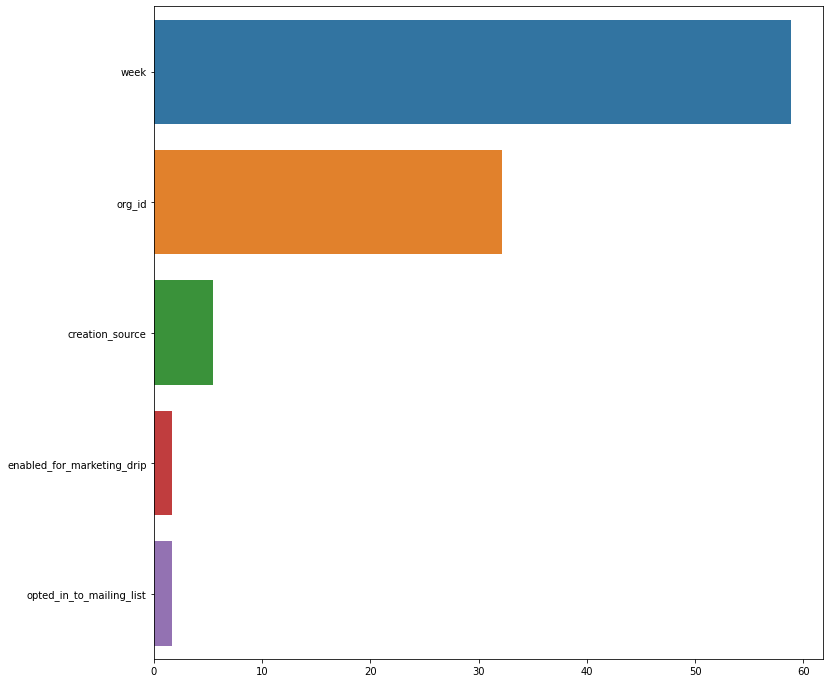

In [102]:
plt.figure(figsize=(12,12))
sns.barplot(x=feature_scores,y=feature_scores.index)
plt.show()